In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [230]:
def get_ix(ds,pft):
    ix=ds.pfts1d_itype_veg==pft
    a=ds.pfts1d_lat[ix]
    o=ds.pfts1d_lon[ix]
    
    nlon=len(ds.lon)
    nlat=len(ds.lat)
    nx=len(a)

    lats=xr.DataArray(np.tile(ds.lat.values.reshape([-1,1,1]),[1,nlon,nx]),dims=['lat','lon','pft'])
    lons=xr.DataArray(np.tile(ds.lon.values.reshape([1,-1,1]),[nlat,1,nx]),dims=['lat','lon','pft'])
    ix=((abs(lats-a)<0.25)&(abs(lons-o)<0.25)).sum(dim='pft')
    
    return ix==1
def pftgrid(da,ds):

    #set up dims for outgoing data array
    dims=[]
    s=[]
    ix=get_ix(ds,1)
    for dim in da.dims:
        if dim !='pft':
            dims.append(dim)
            s.append(len(da[dim]))
    dims=[*dims,*ix.dims]
    s=[*s,*ix.shape]
    ndims=len(dims)

    das=[]
    ix0=[slice(None) for i in range(ndims-2)]

    pfts=np.unique(ds.pfts1d_itype_veg)
    for pft in pfts:
        out=np.zeros(s)+np.nan
        if pft>0:
            ix=get_ix(ds,pft)
            ix2=tuple([*ix0,ix])
            ixp=ds.pfts1d_itype_veg==pft
            out[ix2]=da.isel(pft=ixp)
        das.append(xr.DataArray(out.copy(),dims=dims))

    da_out=xr.concat(das,dim='pft')
    da_out['pft']=pfts
    da_out['lat']=ds.lat
    da_out['lon']=ds.lon
    for dim in da.dims:
        if dim !='pft':
            da_out[dim]=da[dim]

    return da_out

In [233]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

In [43]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][:17]

In [226]:
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

In [298]:
#load pft-average LAI
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')
da = ds.TLAI_pft_avg_2003.sel(pft=range(1,17))
pftranks=np.flip(da.mean(dim='ens').argsort())  #sort pfts by mean LAI

In [238]:
#calculate SP LAI, by pft
lai=amean(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(1,16)).compute()

In [270]:
#calculate pft landarea
tmp=xr.open_dataset('landarea_transient.nc')
lapft=tmp.landarea_pft.sel(time=slice('2003','2014')).mean(dim='time').groupby('pft').sum().compute().sel(pft=range(1,17))

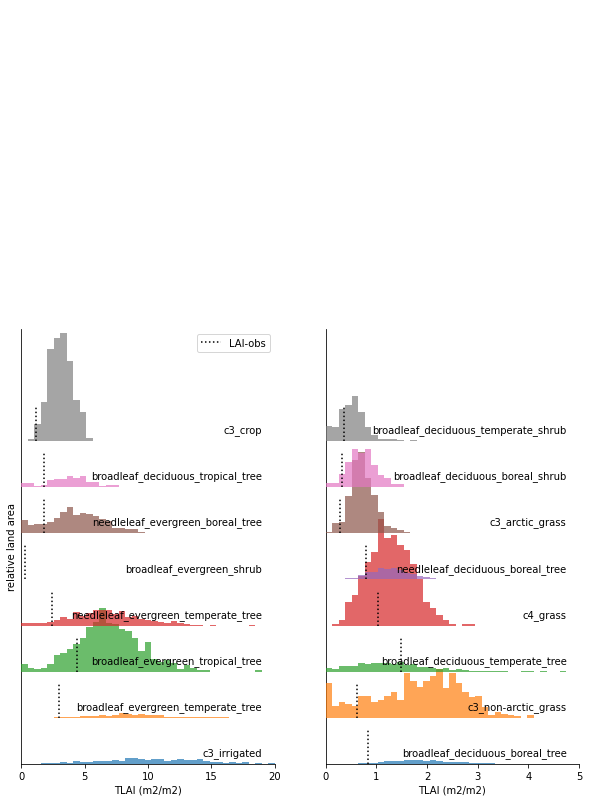

In [299]:

fig, axes = plt.subplots(ncols=2,figsize=[10,8])
ax1,ax2=axes
ax1.set(xlim=(0, 20), ylim=(0, 1e7))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(5*np.arange(5))
ax1.set_yticks([])
ax1.set_xlabel('TLAI (m2/m2)')
ax1.set_ylabel('relative land area')

ax1.plot([],[],'k:',label='LAI-obs')
ax1.legend()


ax2.set(xlim=(0, 5), ylim=(0, 1e7))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yticks([])
ax2.set_xlabel('TLAI (m2/m2)')


for s,pps,bmax,axx in zip([121,122],[pftranks[:8],pftranks[8:]],[20,5],[ax1,ax2]):
    bins = np.linspace(0, bmax, 40)
    xshift=0; yshift=0.08
    for i,pft in enumerate(pps):
        ax= fig.add_subplot(s, sharex=axx, sharey=axx, label="ax2")
        wts=np.tile(lapft.isel(pft=pft)/501,501)
        ax.hist(da.isel(pft=pft),bins,weights=wts,color="C"+str(i),alpha=0.7)
        if pft<15:
            ll=laisp.isel(pft=pft)
            ax.plot([ll,ll],[0,0.08e7],'k:')
        ax.patch.set_visible(False)
        pos = ax.get_position()
        newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0+i*yshift, pos.width, pos.height)
        ax.set_position(newpos)
        ax.axis('off')
        ax.text(0.95*bmax,2e5,pfts[pft.values+1],ha='right')

plt.savefig('../figs/pft/lhc_hists.png',dpi=500,bbox_inches="tight")
